In [1]:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from models.polynomial_regression import (
    train_polynomial_regression,
    evaluate_model,
    train_polynomial_regression_regularized
)
from utils.reporting import format_polynomial_equation


warnings.filterwarnings('ignore')

# Train / Test

In [2]:
# Данные для обучения
# features - независимая переменная x, labels - зависимая переменная y
train_features = np.array([-7.3, -4.7, -4.6, -2.2, 0.5, 3.3, 5.0, 7.0, 7.3]).reshape(-1, 1)
train_labels = np.array([-2.7, -1.2, 2.0, 3.5, 6.0, 5.0, 0.0, -1.7, -4.2])

# Данные для тестирования (две точки)
test_features = np.array([-4.0, 1.5]).reshape(-1, 1)
test_labels = np.array([3.0, 6.0])

# Степени полиномов, которые мы будем исследовать
degrees = [1, 2, 10, 15]

--- Степень: 1 ---
Уравнение: y = 0.78 + (-0.07 * x^1)
TRAIN — MAE: 2.92 	 MSE: 11.13 	 RMSE: 3.34
TEST  — MAE: 3.63 	 MSE: 16.06 	 RMSE: 4.01

--- Степень: 2 ---
Уравнение: y = 5.03 + (0.05 * x^1) + (-0.16 * x^2)
TRAIN — MAE: 1.17 	 MSE: 1.65 	 RMSE: 1.28
TEST  — MAE: 1.00 	 MSE: 1.07 	 RMSE: 1.03

--- Степень: 10 ---
Уравнение: y = 5.9 + (0.15 * x^1) + (-0.11 * x^2) + (0.46 * x^3) + (-0.02 * x^4) + (-0.08 * x^5) + (0.01 * x^6) + (0.0 * x^7) + (-0.0 * x^8) + (-0.0 * x^9) + (0.0 * x^10)
TRAIN — MAE: 0.00 	 MSE: 0.00 	 RMSE: 0.00
TEST  — MAE: 3.78 	 MSE: 23.09 	 RMSE: 4.80

--- Степень: 15 ---
Уравнение: y = 6.0 + (0.0 * x^1) + (-0.0 * x^2) + (0.0 * x^3) + (-0.0 * x^4) + (0.0 * x^5) + (-0.0 * x^6) + (0.0 * x^7) + (-0.01 * x^8) + (0.0 * x^9) + (0.0 * x^10) + (-0.0 * x^11) + (-0.0 * x^12) + (0.0 * x^13) + (0.0 * x^14) + (-0.0 * x^15)
TRAIN — MAE: 0.00 	 MSE: 0.00 	 RMSE: 0.00
TEST  — MAE: 12.29 	 MSE: 300.31 	 RMSE: 17.33



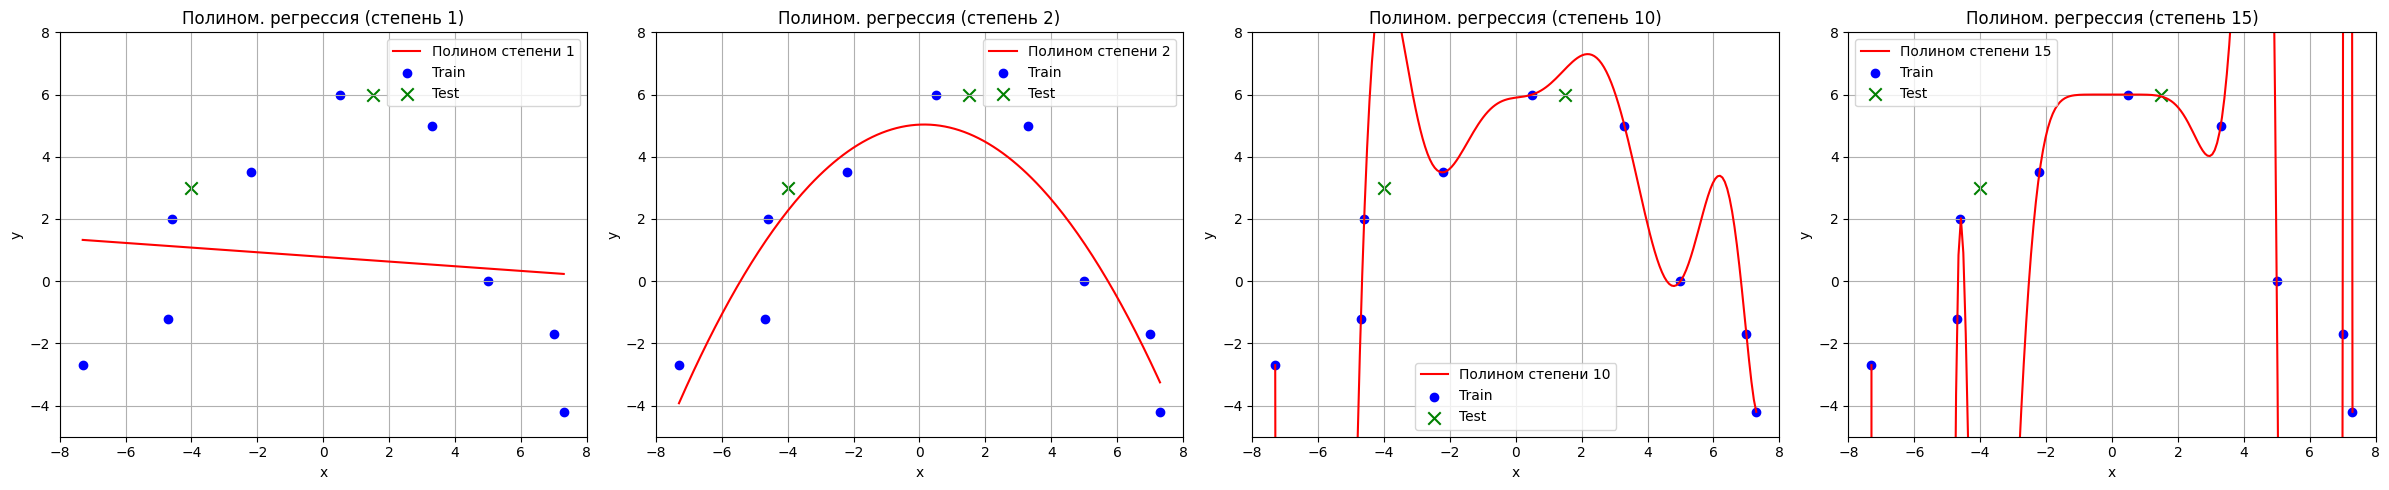

In [3]:
# Создаем сетку графиков: 1 строка, количество столбцов = количеству степеней
# Размер фигуры подбирается пропорционально количеству графиков
fig, axes = plt.subplots(1, len(degrees), figsize=(6 * len(degrees), 5))

# Специальная обработка для случая с одним графиком
# (plt.subplots возвращает не список, а одиночный объект)
if len(degrees) == 1:
    axes = [axes]  # Превращаем одиночный объект в список с одним элементом

# Цикл по всем степеням полиномов
for idx, degree in enumerate(degrees):
    # 1. ОБУЧЕНИЕ МОДЕЛИ
    # Обучаем полиномиальную регрессию указанной степени
    model, poly = train_polynomial_regression(train_features, train_labels, degree)

    # 2. ПРЕОБРАЗОВАНИЕ ДАННЫХ
    # Применяем полиномиальное преобразование к обучающим и тестовым данным
    train_poly = poly.transform(train_features)
    test_poly = poly.transform(test_features)

    # 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ
    # Вычисляем метрики на обучающей и тестовой выборках
    train_mae, train_mse, train_rmse = evaluate_model(model, train_poly, train_labels)
    test_mae, test_mse, test_rmse = evaluate_model(model, test_poly, test_labels)

    # 4. ВЫВОД ИНФОРМАЦИИ
    print(f"--- Степень: {degree} ---")

    # Формируем вектор весов (коэффициентов модели)
    # intercept_ - свободный член, coef_ - коэффициенты при признаках
    # [1:] используется чтобы исключить коэффициент при x^0 (он уже есть в intercept)
    weights = np.concatenate(([model.intercept_], model.coef_[1:]))

    # Форматируем уравнение полинома для красивого вывода
    print("Уравнение:", format_polynomial_equation(weights))

    # Выводим метрики для обучающей и тестовой выборок
    # .2f означает округление до 2 знаков после запятой
    print(f"TRAIN — MAE: {train_mae:.2f} \t MSE: {train_mse:.2f} \t RMSE: {train_rmse:.2f}")
    print(f"TEST  — MAE: {test_mae:.2f} \t MSE: {test_mse:.2f} \t RMSE: {test_rmse:.2f}\n")

    # 5. ВИЗУАЛИЗАЦИЯ
    # Строим график для текущей модели
    x_min = min(train_features.min(), test_features.min())
    x_max = max(train_features.max(), test_features.max())
    x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1)  # Генерируем 200 равномерно распределенных точек в этом диапазоне
    x_range_poly = poly.transform(x_range)  # Преобразуем точки в полиномиальные признаки
    y_range_pred = model.predict(x_range_poly)  # Получаем предсказания модели для всего диапазона

    ax = axes[idx]
    
    # Создаем новую фигуру, если ось не передана
    if ax is None:
        fig, ax = plt.subplots()

    # Отрисовываем кривую полиномиальной регрессии
    ax.plot(x_range, y_range_pred, color='red', label=f"Полином степени {degree}")
    ax.scatter(train_features, train_labels, color='blue', label="Train")
    ax.scatter(test_features, test_labels, color='green', marker='x', s=80, label="Test")

    ax.set_xlim([-8, 8])
    ax.set_ylim([-5, 8])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Полином. регрессия (степень {degree})")
    ax.grid(True)
    ax.legend()
    
# Автоматически регулируем отступы между графиками
plt.tight_layout()

# Показываем все графики
plt.show()

# График сложности модели

In [4]:
# Определяем диапазон степеней полиномов для исследования
# Рассматриваем степени от 1 до 15 включительно
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

# Создаем пустые списки для хранения ошибок:
# train_maes - ошибки на обучающей выборке
# test_maes  - ошибки на тестовой выборке
train_maes = []
test_maes = []

In [5]:
# Цикл по всем степеням полиномов
for degree in degrees:
    # 1. ОБУЧЕНИЕ МОДЕЛИ
    # Обучаем полиномиальную регрессию текущей степени
    # model - обученная модель
    # poly  - полиномиальный преобразователь
    model, poly = train_polynomial_regression(train_features, train_labels, degree)

    # 2. ПРЕОБРАЗОВАНИЕ ДАННЫХ
    # Применяем полиномиальное преобразование к обучающим данным
    train_poly = poly.transform(train_features)
    # Применяем полиномиальное преобразование к тестовым данным
    test_poly = poly.transform(test_features)

    # 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ
    # Вычисляем метрики для обучающей выборки
    # Используем только MAE (остальные метрики игнорируем через _)
    train_mae, _, _ = evaluate_model(model, train_poly, train_labels)
    # Вычисляем метрики для тестовой выборки
    test_mae, _, _ = evaluate_model(model, test_poly, test_labels)

    # 4. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
    # Добавляем MAE обучающей выборки в список train_maes
    train_maes.append(train_mae)
    # Добавляем MAE тестовой выборки в список test_maes
    test_maes.append(test_mae)

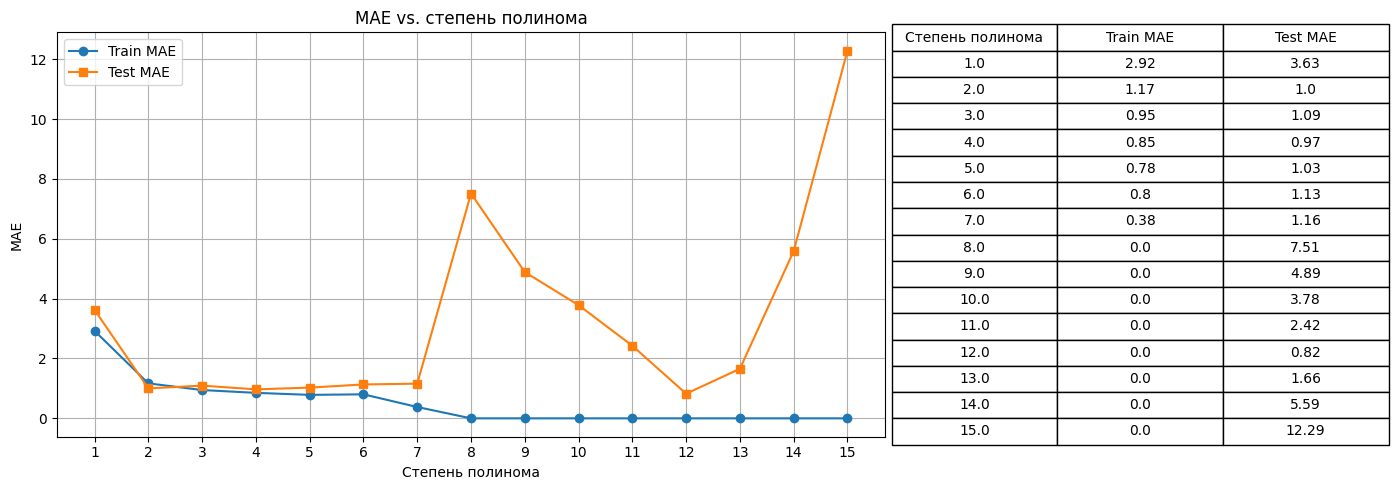

In [6]:
# 5. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# Создаем DataFrame для хранения результатов
results_df = pd.DataFrame({
    "Степень полинома": degrees,
    "Train MAE": train_maes,
    "Test MAE": test_maes
})

# Создаем фигуру с двумя областями: для графика и таблицы
# Соотношение ширины 2:1 (график в два раза шире таблицы)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

# График MAE в первой области (ax1)

ax1.plot(degrees, train_maes, marker='o', label='Train MAE')  # Обучающая ошибка - синяя линия с кружками
ax1.plot(degrees, test_maes, marker='s', label='Test MAE')  # Тестовая ошибка - оранжевая линия с квадратами

ax1.set_xlabel('Степень полинома')
ax1.set_ylabel('MAE')
ax1.set_title('MAE vs. степень полинома')
ax1.set_xticks(degrees)  # Устанавливаем метки на оси X по всем степеням
ax1.legend()
ax1.grid(True)

# Таблица со значениями во второй области (ax2)
# Отключаем оси для области с таблицей
ax2.axis('off')

# Создаем таблицу с округленными значениями
table = ax2.table(
    cellText=np.round(results_df.values, 2),  # Округляем значения до 2 знаков
    colLabels=results_df.columns,  # Заголовки столбцов
    loc='center',  # Размещение по центру
    cellLoc='center'  # Выравнивание текста в ячейках
)

# Настраиваем размер шрифта
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)  # Масштабируем таблицу для лучшего отображения
plt.tight_layout()  # Убираем лишние пробелы вокруг графиков
plt.show()

# Регуляризация

=== Без регуляризации ===
TRAIN — MAE: 0.00 	 MSE: 0.00 	 RMSE: 0.00
TEST  — MAE: 12.29 	 MSE: 300.31 	 RMSE: 17.33

=== L1 (Lasso) ===
TRAIN — MAE: 0.62 	 MSE: 0.74 	 RMSE: 0.86
TEST  — MAE: 0.82 	 MSE: 0.70 	 RMSE: 0.84

=== L2 (Ridge) ===
TRAIN — MAE: 0.52 	 MSE: 0.59 	 RMSE: 0.77
TEST  — MAE: 1.14 	 MSE: 1.30 	 RMSE: 1.14



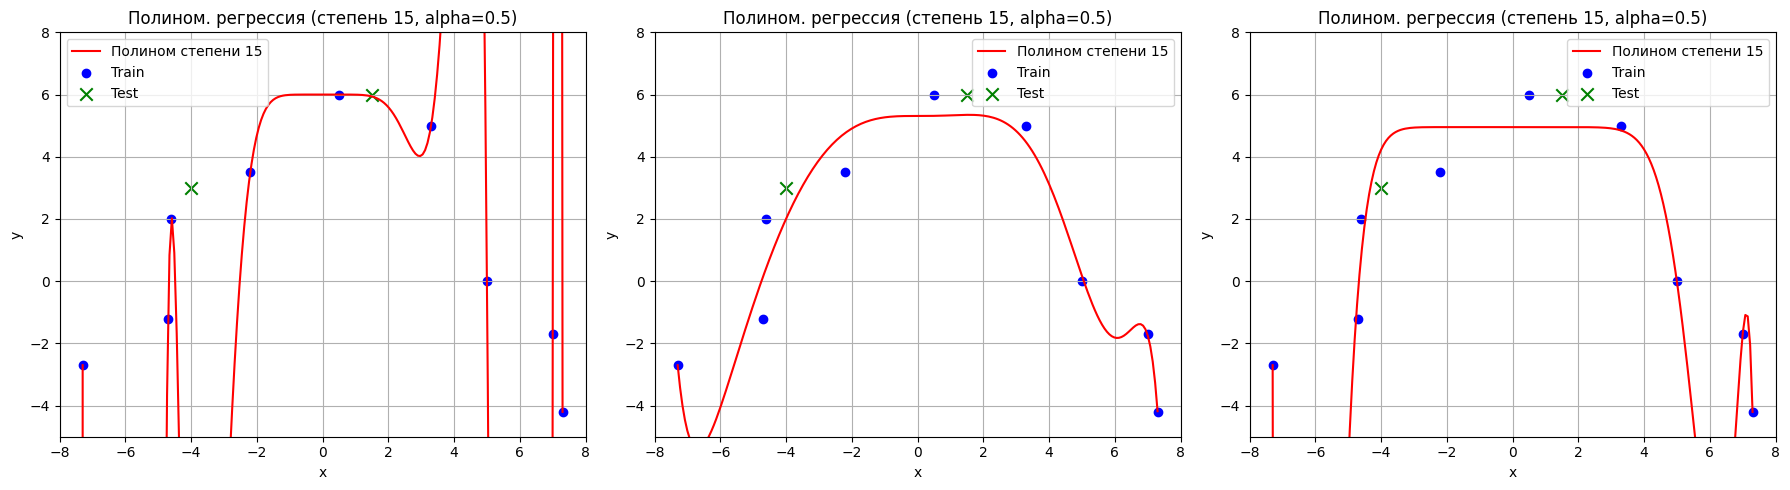

In [7]:
# Устанавливаем высокую степень полинома (риск переобучения) и силу регуляризации
degree = 15  # Степень полинома (очень высокая, может привести к переобучению)
alpha = 0.5  # Коэффициент регуляризации (контролирует силу штрафа за сложность модели)

# Создаем фигуру с тремя графиками в одном ряду
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Определяем три варианта моделей для сравнения
variants = [
    # 1. Модель без регуляризации (базовая)
    ('Без регуляризации', train_polynomial_regression, {}),

    # 2. Модель с L1-регуляризацией (Lasso)
    ('L1 (Lasso)', train_polynomial_regression_regularized, {'penalty': 'l1', 'alpha': alpha}),

    # 3. Модель с L2-регуляризацией (Ridge)
    ('L2 (Ridge)', train_polynomial_regression_regularized, {'penalty': 'l2', 'alpha': alpha})
]

scaler = StandardScaler()

# Перебираем все три варианта моделей
for i, (title, trainer, kwargs) in enumerate(variants):
    # 1. ОБУЧЕНИЕ МОДЕЛИ
    if title == 'Без регуляризации':
        # Для модели без регуляризации используем обычный метод обучения
        model, poly = trainer(train_features, train_labels, degree=degree)
    else:
        # Для регуляризованных моделей передаем дополнительные параметры (penalty и alpha)
        model, poly = trainer(train_features, train_labels, degree=degree, **kwargs)

    # 2. ПРЕОБРАЗОВАНИЕ ДАННЫХ
    # Применяем полиномиальное преобразование к обучающим данным
    train_poly = poly.transform(train_features)
    # Применяем полиномиальное преобразование к тестовым данным
    test_poly = poly.transform(test_features)

    # 3. ОЦЕНКА КАЧЕСТВА МОДЕЛИ
    # Вычисляем метрики на обучающей выборке
    train_mae, train_mse, train_rmse = evaluate_model(model, train_poly, train_labels)
    # Вычисляем метрики на тестовой выборке
    test_mae, test_mse, test_rmse = evaluate_model(model, test_poly, test_labels)

    # 4. ВЫВОД РЕЗУЛЬТАТОВ
    print(f"=== {title} ===")
    print(f"TRAIN — MAE: {train_mae:.2f} \t MSE: {train_mse:.2f} \t RMSE: {train_rmse:.2f}")
    print(f"TEST  — MAE: {test_mae:.2f} \t MSE: {test_mse:.2f} \t RMSE: {test_rmse:.2f}\n")

    # 5. ВИЗУАЛИЗАЦИЯ
    # Создаем диапазон значений x для предсказания
    x_min = min(train_features.min(), test_features.min())
    x_max = max(train_features.max(), test_features.max())
    x_range = np.linspace(x_min, x_max, 200).reshape(-1, 1)  # Генерируем 200 равномерно распределенных точек в этом диапазоне

    x_range_poly = poly.transform(x_range)  # Преобразуем точки в полиномиальные признаки
    y_range_pred = model.predict(x_range_poly)  # Получаем предсказания модели для всего диапазона

    ax = axes[i]
    
    # Создаем новую фигуру, если ось не передана
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(x_range, y_range_pred, color='red', label=f"Полином степени {degree}")  # Отрисовываем кривую полиномиальной регрессии
    ax.scatter(train_features, train_labels, color='blue', label="Train")  # Отображаем обучающие точки синим цветом
    ax.scatter(test_features, test_labels, color='green', marker='x', s=80, label="Test")  # Отображаем тестовые точки зеленым цветом с крестиками

    ax.set_xlim([-8, 8])
    ax.set_ylim([-5, 8])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Полином. регрессия (степень {degree}, alpha={alpha})")
    ax.grid(True)
    ax.legend()

plt.tight_layout()  # Автоматически регулируем отступы между графиками
plt.show()